In [1]:
import pandas as pd

train_df = pd.read_csv("../data/test_task_training_dataset.csv", index_col=0)
hold_out_df = pd.read_csv("../data/test_task_live_dataset.csv", index_col=0)
dataset = pd.read_excel("../data/test_task_dataset.xlsx")

train_df.head()

,loan_id,loan_created_on,loan_amount,loan_term,loan_due,loan_paid,loan_paid_on,loan_issued,client_id,client_birth_date,client_income,client_expenses,client_liabilities,client_debt,loan_is_matured,loan_fully_paid,number_of_previous_loans
0,1,6/15/2019,900,69,1183,1183.0,8/23/2019,1,1,12/31/1981,1150,595,0,0,True,1,0
1,2,5/23/2019,700,90,935,935.0,8/21/2019,1,2,9/10/1998,658,556,0,837,True,1,0
2,6,5/29/2019,1100,30,1407,1407.0,6/28/2019,1,6,1/30/1973,2301,857,1616,50,True,1,0
3,7,6/2/2019,1500,24,1834,NaN,NaN,1,7,11/22/1986,1494,751,2738,0,True,0,0
4,8,5/24/2019,200,30,256,256.0,6/23/2019,1,8,11/13/1986,3196,208,0,0,True,1,0


In [2]:
train_df.shape

(62952, 17)

In [3]:
train_df.loan_issued.unique()

array([1])

In [4]:
hold_out_df.head()

,loan_id,loan_created_on,loan_amount,loan_term,loan_due,loan_issued,client_id,client_birth_date,client_income,client_expenses,client_liabilities,client_debt,number_of_previous_loans
0,99452,2/21/2021,1500,22,1807,1,65652,9/24/1980,3934,795,50,0,0
1,99454,2/6/2021,800,30,1023,1,65654,5/22/2001,2047,104,0,0,0
2,99460,2/12/2021,1100,28,1386,1,65660,8/31/1983,6469,109,50,0,0
3,99461,3/3/2021,900,22,1084,1,65661,7/28/1993,2367,1243,0,0,0
4,99462,3/5/2021,1600,24,1956,1,65662,10/17/1978,12942,18,50,0,0


In [5]:
hold_out_df.shape

(10730, 13)

In [6]:
hold_out_df.loan_issued.unique()

array([1])

In [7]:
list(set(train_df.columns) - set(hold_out_df.columns))

['loan_paid_on', 'loan_fully_paid', 'loan_paid', 'loan_is_matured']

In [8]:
dataset

,loan_id,"unique ID of loan application. If issued, then also represents a unique ID of a loan."
0,created_on,date on which loan application was created. I...
1,loan_amount,loan amount requested by the client. If issue...
2,loan_term,loan term (in days) requested by the client. ...
3,loan_due,total amount that client is expected to repay...
4,loan_paid,total amount repaid by the client for this loan.
5,loan_paid_on,date on which client made a repayment.
6,loan_issued,"1 if this loan was issued to the client, 0 ot..."
7,client_id,unique ID of client.
8,client_birth_date,client's birth date.
9,client_income,client's verified monthly net income at the m...


# Dataset exploration and developing hypotheses

Value to predict: loan_fully_paid.
- The 'loan_fully_paid' flag is measured based on the following condition: **1 if loan_paid/loan_due >= 1, otherwise 0**

# Model for credit risk assessment

In [9]:
train_df.describe()

,loan_id,loan_amount,loan_term,loan_due,loan_paid,loan_issued,client_id,client_income,client_expenses,client_liabilities,client_debt,loan_fully_paid,number_of_previous_loans
count,62952.000000,62952.000000,62952.000000,62952.000000,53333.000000,62952.0,62952.000000,62952.000000,62952.000000,62952.000000,62952.000000,62952.000000,62952.000000
mean,51001.340529,1127.792604,43.653911,1445.927024,1417.606968,1.0,29092.998173,3026.524701,638.005703,185.678183,2250.456364,0.847201,0.595819
std,28630.753764,740.854810,26.114295,965.540929,964.017991,0.0,17984.749660,1955.224262,676.195292,488.275787,13729.679686,0.359796,1.041955
min,1.000000,100.000000,5.000000,105.000000,105.000000,1.0,1.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26296.750000,600.000000,27.000000,767.000000,668.000000,1.0,13964.000000,1612.000000,162.000000,0.000000,0.000000,1.000000,0.000000
50%,51298.000000,1000.000000,30.000000,1269.000000,1251.000000,1.0,27907.500000,2605.000000,423.000000,0.000000,0.000000,1.000000,0.000000
75%,76038.250000,1500.000000,74.000000,1903.000000,1876.000000,1.0,43529.500000,3977.000000,882.000000,88.000000,50.000000,1.000000,1.000000
max,99451.000000,5000.000000,90.000000,6682.000000,7962.000000,1.0,65650.000000,19516.000000,8218.000000,14260.000000,450626.000000,1.000000,11.000000


In [10]:
import sys
sys.path.append("..")

from helper_scripts.preprocessing import clean_dataset

cleaned_train_df = clean_dataset(train_df)
cleaned_train_df.head()

,loan_amount,loan_term,loan_due,client_income,client_expenses,client_liabilities,client_debt,loan_fully_paid,number_of_previous_loans,age
loan_id,,,,,,,,,,
1,900,69,1183,1150,595,0,0,1,0,37.5
2,700,90,935,658,556,0,837,1,0,20.7
6,1100,30,1407,2301,857,1616,50,1,0,46.4
7,1500,24,1834,1494,751,2738,0,0,0,32.5
8,200,30,256,3196,208,0,0,1,0,32.5


In [11]:
cleaned_train_df.describe()

,loan_amount,loan_term,loan_due,client_income,client_expenses,client_liabilities,client_debt,loan_fully_paid,number_of_previous_loans,age
count,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000,57857.000000
mean,1147.610488,43.769604,1471.515737,3036.306895,639.934908,187.632473,2241.401231,0.853086,0.631315,33.943896
std,751.061336,26.164679,978.986398,1962.159030,678.464853,492.084206,13718.279718,0.354023,1.072543,11.049441
min,100.000000,5.000000,105.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,700.000000,27.000000,849.000000,1615.000000,161.000000,0.000000,0.000000,1.000000,0.000000,25.600000
50%,1000.000000,30.000000,1279.000000,2615.000000,424.000000,0.000000,0.000000,1.000000,0.000000,32.100000
75%,1500.000000,74.000000,1918.000000,3992.000000,886.000000,90.000000,50.000000,1.000000,1.000000,40.400000
max,5000.000000,90.000000,6682.000000,18244.000000,8218.000000,14260.000000,360131.000000,1.000000,11.000000,98.600000


In [12]:
cleaned_train_df.duplicated().any()

False

In [13]:
len(train_df.loan_id.unique())

62952

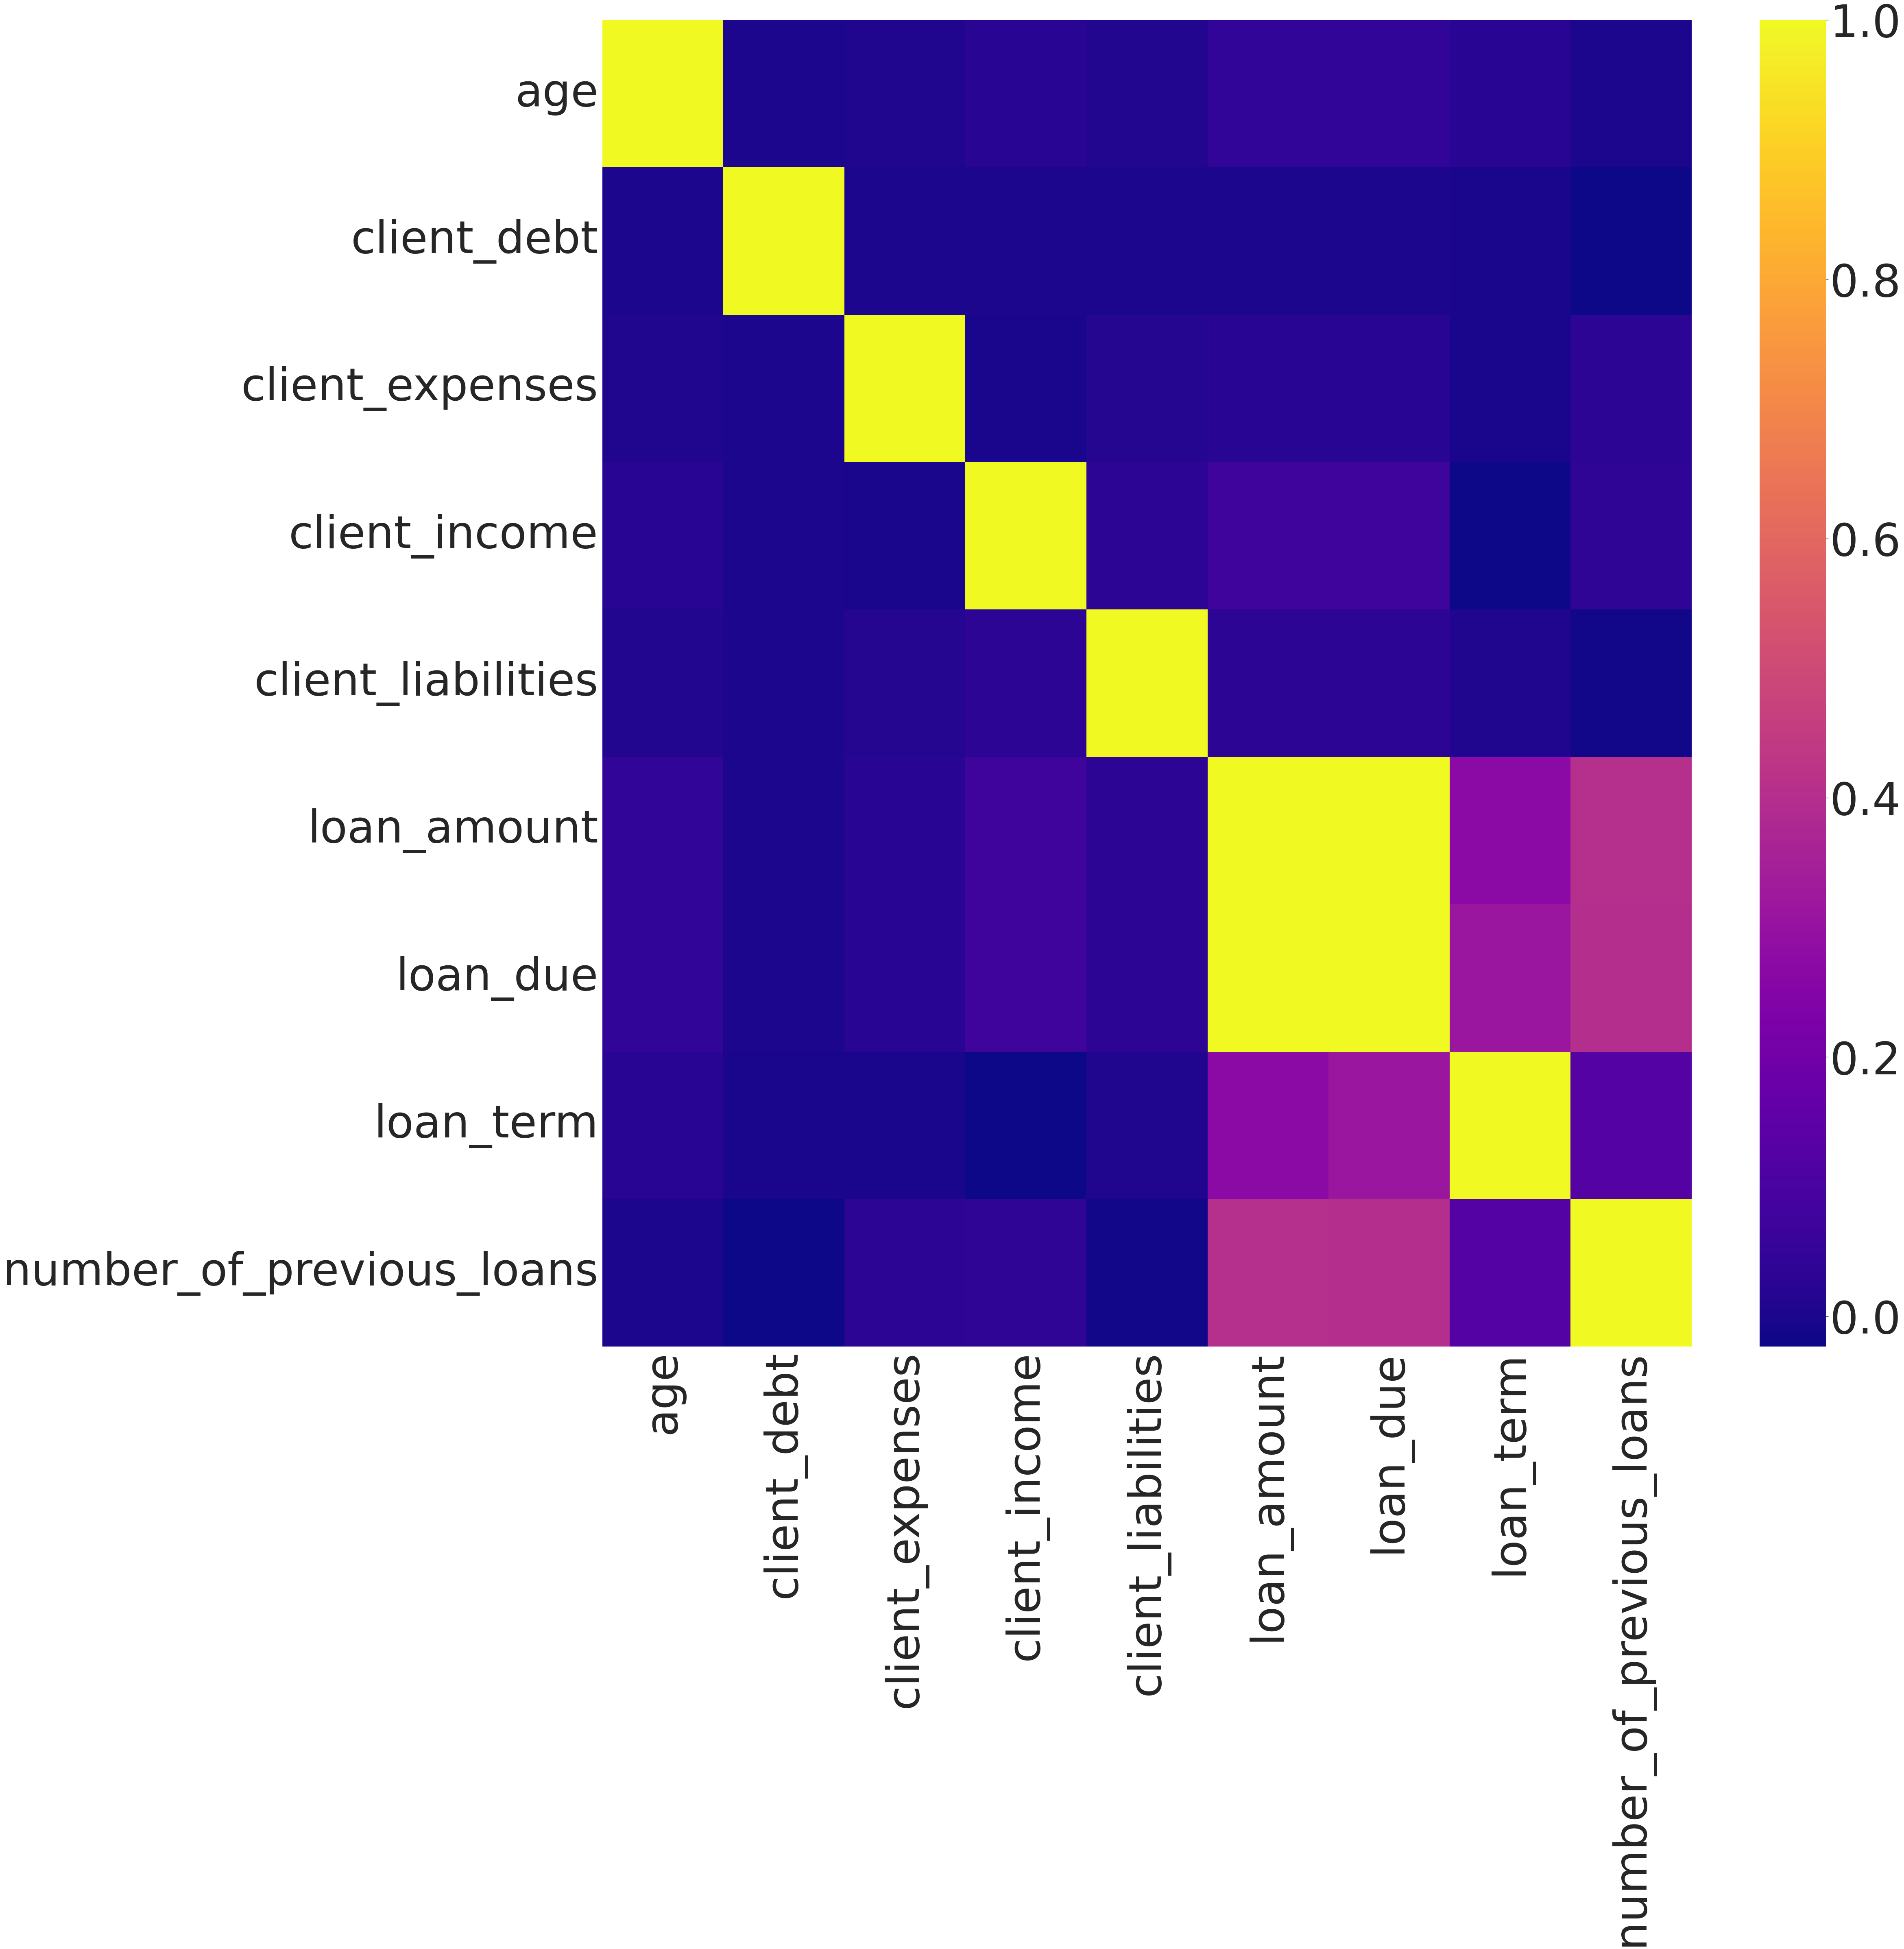

In [40]:
from helper_scripts.correlation import plot_correlation

%matplotlib inline

plot_correlation(cleaned_train_df[cleaned_train_df.columns.difference(['loan_fully_paid'])])

As it might be seen from the picture above, loan_amount and loan_due variables have a Pearson's correlation coefficient value about 1, it indicates that one of these features should be eliminated as another one has already a discriminative power. Variables loan_term and loan_amount have correlation coefficient value that lies between 0.2 and 0.4, so they still can be kept, according to current pattern of data.

In [15]:
from helper_scripts.correlation import get_highly_correlated_vars

# get the feature(s) with Pearson's correlation value that is out of range (-0,8, 0.8):
correlated = get_highly_correlated_vars(cleaned_train_df[cleaned_train_df.columns.difference(['loan_fully_paid'])])
correlated

['loan_due']

In [16]:
train_df.shape

(62952, 17)

In [17]:
len(train_df.client_id.unique())

40638

In [18]:
cleaned_train_df.isna().sum()

loan_amount                 0
loan_term                   0
loan_due                    0
client_income               0
client_expenses             0
client_liabilities          0
client_debt                 0
loan_fully_paid             0
number_of_previous_loans    0
age                         0
dtype: int64

In [19]:
cleaned_train_df['loan_fully_paid'].value_counts()

1    49357
0     8500
Name: loan_fully_paid, dtype: int64

In [20]:
cleaned_train_df['loan_fully_paid'].value_counts() / float(len(cleaned_train_df))

1    0.853086
0    0.146914
Name: loan_fully_paid, dtype: float64

In [21]:
cleaned_train_df.shape

(57857, 10)

# Model 1: random forest classifier on unbalanced data

In [22]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()

X = cleaned_train_df[cleaned_train_df.columns.difference(['loan_fully_paid', 'loan_due'])]
y = cleaned_train_df['loan_fully_paid'].values

clf = RandomForestClassifier()
scoring = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc', 'f1_weighted']
steps = [('transformer', scaler), ('estimator', clf)]
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5)
cv_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_estimator=True)

In [23]:
np.mean(cv_scores['test_precision_weighted'])

0.8355419885177323

In [24]:
np.mean(cv_scores['test_recall_weighted'])

0.8616770525070677

In [25]:
np.mean(cv_scores['test_balanced_accuracy'])

0.5731017023917213

In [26]:
np.mean(cv_scores['test_roc_auc'])

0.7352783894143807

In [27]:
np.mean(cv_scores['test_f1_weighted'])

0.8249937287791209

## Model 2: random forest classifier on data over-sampled using SMOTE

In [28]:
scaler = StandardScaler()

X = cleaned_train_df[cleaned_train_df.columns.difference(['loan_fully_paid', 'loan_due'])]
y = cleaned_train_df['loan_fully_paid'].values

clf = RandomForestClassifier()
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
steps = [('transformer', scaler), ('over', SMOTE()), ('estimator', clf)]
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5)
cv_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_estimator=True)

In [29]:
np.mean(cv_scores['test_precision'])

0.8841106137830588

In [30]:
np.mean(cv_scores['test_recall'])

0.9303504405825913

In [31]:
np.mean(cv_scores['test_accuracy'])

0.8363557065423013

In [32]:
np.mean(cv_scores['test_roc_auc'])

0.7283667841140687

In [33]:
np.mean(cv_scores['test_f1'])

0.9063454552663719

# Prediction on the live dataset


In [34]:
test_df = clean_dataset(hold_out_df)
test_df.drop('loan_due', inplace=True, axis=1)
test_df.duplicated().any()

False

In [35]:
test_df.head()

,loan_amount,loan_term,client_income,client_expenses,client_liabilities,client_debt,number_of_previous_loans,age
loan_id,,,,,,,,
99452,1500,22,3934,795,50,0,0,40.4
99454,800,30,2047,104,0,0,0,19.7
99460,1100,28,6469,109,50,0,0,37.5
99461,900,22,2367,1243,0,0,0,27.6
99462,1600,24,12942,18,50,0,0,42.4


In [36]:
test_df.isna().sum()

loan_amount                 0
loan_term                   0
client_income               0
client_expenses             0
client_liabilities          0
client_debt                 0
number_of_previous_loans    0
age                         0
dtype: int64

In [37]:
test_df.shape

(9949, 8)

In [38]:
from sklearn.pipeline import Pipeline


scaler = StandardScaler()
clf = RandomForestClassifier()

steps = [('transformer', scaler), ('estimator', clf)]
pipeline = Pipeline(steps=steps)


pipeline.fit(X, y)
test_df = test_df[X.columns.values] #re-arrange the order of columns
predictions = pipeline.predict(test_df)
pd.DataFrame(predictions).to_csv("../data/predictions.csv")

In [39]:
pd.DataFrame(predictions).value_counts()

1    9608
0     341
dtype: int64